In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import cv2
import numpy as np
import torchdata.datapipes as dp
#import boto3
import os
#import skimage
import PIL.Image
import json
import fsspec
from src.globals import DATA_DIR, LABELS_TO_INDS
from pathlib import Path

/home/pfuerste/miniconda3/envs/mi4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook is supposed to show how torchdata datapipes work nad how to defines functions for them. All functions in this notebook are also contained in /src, but are listed here for readability.

## "Normal" functions

In [2]:
def download_from_s3(bucket: str, remote_path: str, local_path: str, s3_client=None):
    if not s3_client:
        s3_client = boto3.client("s3")
    s3_client.download_file(bucket, remote_path, local_path)


def split_bucket_from_path(x: str):
    return "".join(x.split("/")[2:3]), "/".join(x.split("/")[3:])


def combine_bands(arrays: list[np.array], max_res=(120, 120)):
    """Combines bands into one array, upscaling each band to max_res.

    Args:
        arrays (list): list of bands
        max_res (tuple, optional): Max height & width to resize bands to. Defaults to (120, 120).

    Returns:
        np.array: Concatenated & resized bands.
    """
    result = np.zeros(shape=(*max_res, len(arrays)))
    for i, array in enumerate(arrays):
        assert array.shape[0] <= max_res[0]
        assert array.shape[1] <= max_res[1]
        result[:, :, i] = cv2.resize(array, dsize=max_res)
    return result


def get_first_n_pcs(img: np.array, num_components: int):
    """Perform PCA on a single image and return principle components which make up the most variance.

    Args:
        img (np.array): Original image of shape (h, w, num_bands).
        num_components (int): Desired number of components to be returned.

    Returns:
        np.array: Components with shape (h, w, num_components).
    """
    # Convert 2d bands into 1-d arrays
    bands_vectorized = np.zeros(shape=(img.shape[0] * img.shape[1], img.shape[2]))
    for i in range(img.shape[-1]):
        flattened_band = img[:, :, i].flatten()
        flattened_band_standard = (
            flattened_band - flattened_band.mean()
        ) / flattened_band.std()
        bands_vectorized[:, i] = flattened_band_standard

    cov = np.cov(bands_vectorized.transpose())
    eig_val, eig_vec = np.linalg.eig(cov)

    # Ordering Eigen values and vectors
    order = eig_val.argsort()[::-1]
    eig_val = eig_val[order]
    eig_vec = eig_vec[:, order]

    # Projecting data on Eigen vector directions resulting in Principal Components
    pcs = np.matmul(bands_vectorized, eig_vec)

    # Rearranging 1-d arrays to 2-d arrays of image size
    PC_2d = np.zeros((num_components, img.shape[0], img.shape[1]))
    for i in range(num_components):
        PC_2d[i, :, :] = pcs[:, i].reshape(-1, img.shape[1])

    # normalizing between 0 to 255
    PC_2d_Norm = np.zeros((num_components, img.shape[0], img.shape[1]))
    for i in range(num_components):
        PC_2d_Norm[i, :, :] = cv2.normalize(
            PC_2d[i, :, :], np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX
        )

    return PC_2d_Norm[: num_components + 1, :, :]

## Data Pipes
Iterable datapipes use a number of transformations to return an iterator, which can be used as a dataset argument for a pytorch dataloader if it returns dictionaries with keys "data" and "label".
Here, the folders in one directory are listed by one pipe and a second one is initialized using a list of the first one. The second pipe performs a set of operations to merge the bands (which are stored as individual files) into one array, apply PCA on these images and retrieve the labels from json files. The second datapipe can then be used to construct a dataloader to begin training.  

In [3]:
def get_s3_folder_content(bucket_path=f"s3://mi4people-soil-project/BigEarthNet-v1.0/"):
    """Gets all top level-elements in buckets path.

    Args:
        bucket_path (string, optional): Path in bucket to list elements from. Defaults to f"s3://mi4people-soil-project/BigEarthNet-v1.0/".
    Returns:
        list: list of full paths of all top-level-elements.
    """
    top_pipe = dp.iter.IterableWrapper([bucket_path])
    top_pipe = top_pipe.list_files_by_fsspec()
    return top_pipe

In [4]:
def group_key_by_folder(path_and_stream):
    return "".join(path_and_stream[0].split("/")[-1].split("_")[:5])


def chunk_to_dataloader_dict(chunk):
    json_files = [path for path in chunk if path.endswith(".json")]
    assert len(json_files) == 1, "Only one label json per image is permitted."
    image_files = [path for path in chunk if path.endswith(".tif")]
    return {"label": json_files[0], "data": image_files}


def read_json_from_path(path):
    json_content = json.loads(fsspec.open(path, mode="r").open().read())
    return json_content


def read_imgs_from_paths(path_list):
    image_contents = [
        np.array(PIL.Image.open(fsspec.open(path, mode="rb").open()))
        for path in path_list
    ]
    return image_contents


def get_labels(meta_dict):
    return meta_dict["labels"]


def get_label_inds(label_list):
    return [LABELS_TO_INDS[label] for label in label_list]


def pca_on_label_and_data(combined_image):
    return get_first_n_pcs(combined_image, num_components=3)

In [59]:
file_list = list(get_s3_folder_content())[:1000]

In [60]:
from src.data.bigearthnet_datapipes import  get_bigearth_pca_pipe, get_bigearth_no_pca_pipe
pca_out = list(get_bigearth_pca_pipe(file_list))
img_out = list(get_bigearth_no_pca_pipe(file_list))

In [62]:
for i in range(1000):
    # find some images which are not sea (!=36)
    print(i, img_out[i]["label"].tolist().index(1))


0 36
1 36
2 36
3 36
4 36
5 36
6 36
7 36
8 36
9 36
10 36
11 36
12 36
13 36
14 36
15 36
16 36
17 36
18 36
19 36
20 36
21 36
22 36
23 36
24 36
25 36
26 36
27 36
28 36
29 36
30 36
31 36
32 36
33 36
34 36
35 36
36 36
37 36
38 36
39 36
40 36
41 36
42 36
43 36
44 36
45 36
46 36
47 36
48 36
49 36
50 36
51 36
52 36
53 36
54 36
55 36
56 36
57 36
58 36
59 36
60 36
61 36
62 36
63 36
64 36
65 22
66 9
67 9
68 22
69 22
70 22
71 22
72 9
73 9
74 9
75 9
76 9
77 36
78 22
79 22
80 9
81 9
82 9
83 9
84 9
85 9
86 9
87 9
88 36
89 36
90 36
91 36
92 36
93 36
94 36
95 36
96 36
97 36
98 36
99 36
100 36
101 36
102 36
103 36
104 36
105 36
106 36
107 36
108 36
109 36
110 36
111 36
112 36
113 36
114 36
115 36
116 36
117 36
118 22
119 36
120 36
121 22
122 5
123 5
124 9
125 9
126 22
127 22
128 22
129 36
130 22
131 22
132 22
133 9
134 9
135 9
136 9
137 9
138 9
139 9
140 9
141 36
142 36
143 36
144 36
145 36
146 36
147 36
148 36
149 36
150 36
151 36
152 36
153 36
154 36
155 36
156 36
157 36
158 36
159 36
160 36
161 36
162

In [64]:
#from src.infrastructure.aws_infrastructure import download_from_s3
i = 66
pca_img = pca_out[i]["data"]
og_img = img_out[i]["data"]
print(img_out[i]["label"])
#og_img = download_from_s3("mi4people-soil-project", "BigEarthNet-v1.0/S2A_MSIL2A_20170613T101031_0_45", "dl_img")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


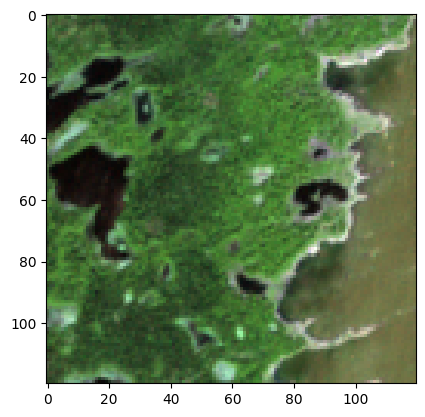

In [74]:
reshaped_og = np.zeros((120, 120, 3))
reshaped_og[:, :, 0] = og_img[:,:,1]/np.max(og_img[:,:,1])
reshaped_og[:, :, 1] = og_img[:,:,2]/np.max(og_img[:,:,2])
reshaped_og[:, :, 2] = og_img[:,:,3]/np.max(og_img[:,:,3])
plt.imshow(reshaped_og)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


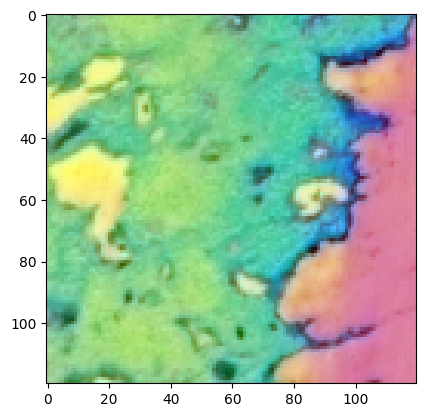

In [83]:
reshaped_pca = np.zeros((120, 120, 3))
reshaped_pca[:, :, 0] = pca_img[0,:,:]/np.max(pca_img[0,:,:])
reshaped_pca[:, :, 1] = pca_img[1,:,:]/np.max(pca_img[1,:,:])
reshaped_pca[:, :, 2] = pca_img[2,:,:]/np.max(pca_img[2,:,:])
plt.imshow(reshaped_pca)

## Old stuff

In [ ]:
import torch
loader = torch.utils.data.DataLoader(dataset=get_bigearth_pca_pipe(file_list))

In [ ]:
for sample in loader:
    print(type(sample["data"]))
    print(sample["data"].shape)

<class 'torch.Tensor'>
torch.Size([1, 3, 120, 120])
<class 'torch.Tensor'>
torch.Size([1, 3, 120, 120])
<class 'torch.Tensor'>
torch.Size([1, 3, 120, 120])
<class 'torch.Tensor'>
torch.Size([1, 3, 120, 120])
<class 'torch.Tensor'>
torch.Size([1, 3, 120, 120])


In [ ]:
img_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
img_pipe = img_pipe.list_files_by_fsspec()
img_pipe = img_pipe.filter(filter_fn=lambda x: x.endswith(".tif"))
img_pipe = img_pipe.open_files_by_fsspec(mode="rb")
img_pipe = img_pipe.map(lambda x: (x[0], PIL.Image.open(x[1])))

gt_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
gt_pipe = gt_pipe.list_files_by_fsspec()
gt_pipe = gt_pipe.filter(filter_fn=lambda x: x.endswith(".json"))
gt_pipe = gt_pipe.open_files_by_fsspec()
# gt_pipe = gt_pipe.parse_json_files()
# gt_pipe = gt_pipe.map(lambda x: json.loads(x[1].read())["labels"])


gt_list = [x for x in gt_pipe]
gt_list = list(gt_pipe)
print(gt_list)
img_list = [x for x in img_pipe]

NameError: name 'folder' is not defined

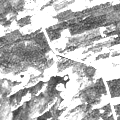

In [ ]:
np.array(img_list[1]).shape
img_list[1].show()

In [ ]:
# Download one folder to local
folder = "S2A_MSIL2A_20170613T101031_14_65/"
bucketname = f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"
pipe = dp.iter.IterableWrapper([bucketname])
pipe = pipe.list_files_by_fsspec()

tifs = [x for x in pipe if ".tif" in x]
for tif in tifs:
    bucket, remote = split_bucket_from_path(tif)
    file = tif.split("/")[-1]
    if not os.path.isdir(
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
    ):
        os.mkdir(
            f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        )
    local = (
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        + file
    )
    download_from_s3(bucket=bucket, remote_path=remote, local_path=local)

tif_dir = f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
local_tifs = [os.path.join(tif_dir, x) for x in os.listdir(tif_dir)]
imgs = [skimage.io.imread(path) for path in local_tifs]
bands = [tif.split("_")[-1].split(".")[0] for tif in local_tifs]
resized = combine_bands(imgs)